In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import re
import numpy as np
import multiprocessing
from collections import Counter
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from IPython.display import clear_output
import nltk
# nltk.download('popular', halt_on_error=False)
# nltk.download('all', halt_on_error=False)
clear_output(wait=False)

In [2]:
nlp = spacy.load("en_core_web_sm", enable = ['ner'], disable= ["tagger", "parser", "textcat"])
nlp.add_pipe("merge_entities")
print(nlp.pipe_names)
print(nlp.analyze_pipes(pretty = True))

['ner', 'merge_entities']

============================= Pipeline Overview =============================

#   Component        Assigns          Requires         Scores          Retokenizes
-   --------------   --------------   --------------   -------------   -----------
0   ner              doc.ents                          ents_f          False      
                     token.ent_iob                     ents_p                     
                     token.ent_type                    ents_r                     
                                                       ents_per_type              
                                                                                  
1   merge_entities                    doc.ents                         True       
                                      token.ent_iob                               
                                      token.ent_type                              

✔ No problems found.
{'summary': {'ner': {'assigns': ['doc.ents

In [3]:
%time df = pd.read_parquet('data_final_vader.parquet',engine = 'pyarrow')

CPU times: user 54.1 s, sys: 15.2 s, total: 1min 9s
Wall time: 51 s


In [4]:
pos_df = df[df['sentiment']=="Positive"]
neg_df = df[df['sentiment']=="Negative"]

In [5]:
print(pos_df.shape,'\t',neg_df.shape)

(170643, 18) 	 (11280, 18)


In [6]:
pos_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens'],
      dtype='object')

In [10]:
pd.set_option('display.max_colwidth',300)
pos_df[['text','text_clean']].head(1)

,text,text_clean
0,\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanis...,Artificial intelligence improves parking efficiency Chinese cities People Daily Online Home China Politics Foreign Affairs Opinions Video We Are China Business Military World Society Culture Travel Science Sports Photo Languages Chinese Japanese French Spanish Russian Arabic Korean German Portug...


In [11]:
df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens'],
      dtype='object')

In [22]:
def extract_entities(text):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'LOC', 'GPE', 'PERSON'] :
            entities.append(ent.text)
    return entities

In [13]:
pandarallel.initialize(nb_workers=60, use_memory_fs =False, progress_bar =True)

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Overall entities in both positve and negative sentiment data

### Entities from Positive Sentiment Articles

In [23]:
%%time
pos_df['entities'] = pos_df['text_clean'].parallel_apply(lambda x: extract_entities(x))

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



CPU times: user 1min 57s, sys: 27.1 s, total: 2min 24s
Wall time: 5min 3s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
pos_ents = [entity for entities in pos_df["entities"] for entity in entities]
len(pos_ents)

11524805

In [26]:
pos_ents_df = pd.DataFrame(Counter(pos_ents).most_common(15), columns=['Entity','Frequency'])
pos_ents_df

,Entity,Frequency
0,AI,849416
1,US,252034
2,Microsoft,78854
3,Google,66549
4,India,65850
5,China,55739
6,Us,50229
7,OpenAI,49670
8,PRNewswire,44004
9,Gray Television Inc,43343


### Entities from Negative Sentiment Articles

In [15]:
%%time
neg_df['entities'] = neg_df['text_clean'].parallel_apply(lambda x: extract_entities(x))

CPU times: user 7.31 s, sys: 10.4 s, total: 17.7 s
Wall time: 30.1 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
neg_ents = [entity for entities in neg_df["entities"] for entity in entities]
len(neg_ents)

809282

In [27]:
neg_ents_df = pd.DataFrame(Counter(neg_ents).most_common(15), columns=['Entity','Frequency'])
neg_ents_df

,Entity,Frequency
0,AI,49688
1,US,15388
2,Google,7828
3,Microsoft,7559
4,OpenAI,6458
5,China,6029
6,Us,4245
7,India,3541
8,AP,3352
9,Russia,3335


### Extract the entities separately for ORG, LOC and PERSON 

In [31]:
def extract_entities(text, ent_types):
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        if ent.label_ in ent_types:
            entities.append(ent.text)
    return entities

#### Positve Sentiments

In [38]:
pandarallel.initialize(nb_workers = 60, use_memory_fs=False, progress_bar = False)

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [39]:
%%time
pos_df['org_ents'] = pos_df['text_clean'].parallel_apply(lambda x: extract_entities(x, ent_types = ["ORG"]))

CPU times: user 4.4 s, sys: 13.7 s, total: 18.1 s
Wall time: 4min 56s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
%%time
pos_df['loc_ents'] = pos_df['text_clean'].parallel_apply(lambda x: extract_entities(x, ent_types = ["LOC", "GPE"]))

CPU times: user 1.69 s, sys: 11.6 s, total: 13.3 s
Wall time: 4min 57s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [49]:
%%time
pos_df['person_ents'] = pos_df['text_clean'].parallel_apply(lambda x: extract_entities(x, ent_types = ["PERSON"]))

CPU times: user 2.48 s, sys: 11.6 s, total: 14.1 s
Wall time: 4min 57s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [50]:
pos_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens',
       'entities', 'org_ents', 'loc_ents', 'person_ents'],
      dtype='object')

In [4]:
pos_orgs = [entity for entities in pos_df['org_ents'] for entity in entities]
pos_locs = [entity for entities in pos_df["loc_ents"] for entity in entities]
pos_persons = [entity for entities in pos_df["person_ents"] for entity in entities]

In [5]:
pos_orgs_df = pd.DataFrame(Counter(pos_orgs).most_common(30), columns=['Entity','Frequency'])
pos_orgs_df

,Entity,Frequency
0,AI,838300
1,Microsoft,78834
2,Google,66542
3,PRNewswire,44004
4,Gray Television Inc,43343
5,Gray Media Group,42707
6,Gray Media Group Inc Station,37194
7,IBM,29418
8,GPT,26315
9,Amazon,22237


In [6]:
pos_locs_df = pd.DataFrame(Counter(pos_locs).most_common(30), columns=['Entity','Frequency'])
pos_locs_df

,Entity,Frequency
0,US,252034
1,India,65850
2,China,55739
3,Us,50223
4,OpenAI,45795
5,UK,41680
6,Japan,26384
7,France,24888
8,Canada,22995
9,Russia,22884


In [7]:
pos_person_df = pd.DataFrame(Counter(pos_persons).most_common(30), columns=['Entity','Frequency'])
pos_person_df = pos_person_df[~pos_person_df['Entity'].str.endswith("https")].reset_index(drop=True)
pos_person_df = pos_person_df[~pos_person_df['Entity'].str.startswith("https")].reset_index(drop=True)
pos_person_df

,Entity,Frequency
0,WhatsApp,18920
1,Covid,10714
2,Twitter,10516
3,AI,7704
4,Biden,7100
5,Elon Musk,6168
6,YouTube Instagram,6143
7,Dashboard Profile,5727
8,Googles,5216
9,Get Android,5206


#### Negative Sentiments

In [55]:
pandarallel.initialize(nb_workers = 60, use_memory_fs=False, progress_bar = False)

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [56]:
%%time
neg_df['org_ents'] = neg_df['text_clean'].parallel_apply(lambda x: extract_entities(x, ent_types = ["ORG"]))

CPU times: user 678 ms, sys: 9.69 s, total: 10.4 s
Wall time: 32 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:
%%time
neg_df['loc_ents'] = neg_df['text_clean'].parallel_apply(lambda x: extract_entities(x, ent_types = ["LOC", "GPE"]))

CPU times: user 97.3 ms, sys: 10.5 s, total: 10.6 s
Wall time: 30.9 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
%%time
neg_df['person_ents'] = neg_df['text_clean'].parallel_apply(lambda x: extract_entities(x, ent_types = ["PERSON"]))

CPU times: user 144 ms, sys: 9.52 s, total: 9.66 s
Wall time: 30.8 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
neg_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens',
       'entities', 'org_ents', 'loc_ents', 'person_ents'],
      dtype='object')

In [8]:
neg_orgs = [entity for entities in neg_df['org_ents'] for entity in entities]
neg_locs = [entity for entities in neg_df["loc_ents"] for entity in entities]
neg_persons = [entity for entities in neg_df["person_ents"] for entity in entities]

In [9]:
neg_orgs_df = pd.DataFrame(Counter(neg_orgs).most_common(30), columns=['Entity','Frequency'])
neg_orgs_df

,Entity,Frequency
0,AI,48731
1,Google,7826
2,Microsoft,7559
3,AP,3344
4,Trump,2467
5,EU,1701
6,GPT,1699
7,Bing,1657
8,COVID,1617
9,Bard,1480


In [10]:
neg_locs_df = pd.DataFrame(Counter(neg_locs).most_common(30), columns=['Entity','Frequency'])
neg_locs_df

,Entity,Frequency
0,US,15388
1,China,6029
2,OpenAI,5958
3,Us,4245
4,India,3541
5,Russia,3335
6,UK,3120
7,Florida,3050
8,Ukraine,2673
9,New York,2556


In [11]:
neg_person_df = pd.DataFrame(Counter(neg_persons).most_common(30), columns=['Entity','Frequency'])
neg_person_df

,Entity,Frequency
0,Jones,2800
1,Get Android,1965
2,Biden,1754
3,Twitter,1744
4,Musk,1530
5,Covid,1475
6,Donald Trump,1312
7,Elon Musk,1179
8,Ai Weiwei,1125
9,Putin,879


In [64]:
%%time
pos_df.to_parquet('ner_pos_df.parquet')
neg_df.to_parquet('ner_neg_df.parquet')

CPU times: user 1min, sys: 10.8 s, total: 1min 11s
Wall time: 1min 24s


In [3]:
%%time
pos_df = pd.read_parquet("ner_pos_df.parquet", engine='pyarrow')
neg_df = pd.read_parquet("ner_neg_df.parquet", engine='pyarrow')

CPU times: user 57.9 s, sys: 13.8 s, total: 1min 11s
Wall time: 1min 23s


In [12]:
# Create a list of the dataframes
pos_ents_comb = pd.concat([pos_orgs_df.rename(columns={"Entity": "pos_org", "Frequency": "org_freq"}),
                           pos_locs_df.rename(columns={"Entity": "pos_loc", "Frequency": "loc_freq"}),
                           pos_person_df.rename(columns={"Entity": "pos_person", "Frequency": "person_freq"})],
                          ignore_index=False, axis =1)

pos_ents_comb

,pos_org,org_freq,pos_loc,loc_freq,pos_person,person_freq
0,AI,838300,US,252034,WhatsApp,18920.0
1,Microsoft,78834,India,65850,Covid,10714.0
2,Google,66542,China,55739,Twitter,10516.0
3,PRNewswire,44004,Us,50223,AI,7704.0
4,Gray Television Inc,43343,OpenAI,45795,Biden,7100.0
5,Gray Media Group,42707,UK,41680,Elon Musk,6168.0
6,Gray Media Group Inc Station,37194,Japan,26384,YouTube Instagram,6143.0
7,IBM,29418,France,24888,Dashboard Profile,5727.0
8,GPT,26315,Canada,22995,Googles,5216.0
9,Amazon,22237,Russia,22884,Get Android,5206.0


In [13]:
overall_pos_ents = pd.concat([pos_orgs_df,pos_locs_df,pos_person_df]).sort_values(by="Frequency", ascending=False).reset_index(drop=True)

In [14]:
overall_pos_ents.head(15)

,Entity,Frequency
0,AI,838300
1,US,252034
2,Microsoft,78834
3,Google,66542
4,India,65850
5,China,55739
6,Us,50223
7,OpenAI,45795
8,PRNewswire,44004
9,Gray Television Inc,43343


In [15]:
#Negative entitites
neg_ents_comb = pd.concat([neg_orgs_df.rename(columns={"Entity": "neg_org", "Frequency": "org_freq"}),
                           neg_locs_df.rename(columns={"Entity": "neg_loc", "Frequency": "loc_freq"}),
                           neg_person_df.rename(columns={"Entity": "neg_person", "Frequency": "person_freq"})],
                          ignore_index=False, axis =1)

neg_ents_comb

,neg_org,org_freq,neg_loc,loc_freq,neg_person,person_freq
0,AI,48731,US,15388,Jones,2800
1,Google,7826,China,6029,Get Android,1965
2,Microsoft,7559,OpenAI,5958,Biden,1754
3,AP,3344,Us,4245,Twitter,1744
4,Trump,2467,India,3541,Musk,1530
5,EU,1701,Russia,3335,Covid,1475
6,GPT,1699,UK,3120,Donald Trump,1312
7,Bing,1657,Florida,3050,Elon Musk,1179
8,COVID,1617,Ukraine,2673,Ai Weiwei,1125
9,Bard,1480,New York,2556,Putin,879


In [16]:
overall_neg_ents = pd.concat([neg_orgs_df,neg_locs_df,neg_person_df]).sort_values(by="Frequency", ascending=False).reset_index(drop=True)
overall_neg_ents.head(20)

,Entity,Frequency
0,AI,48731
1,US,15388
2,Google,7826
3,Microsoft,7559
4,China,6029
5,OpenAI,5958
6,Us,4245
7,India,3541
8,AP,3344
9,Russia,3335


In [17]:
neg_ents_comb

,neg_org,org_freq,neg_loc,loc_freq,neg_person,person_freq
0,AI,48731,US,15388,Jones,2800
1,Google,7826,China,6029,Get Android,1965
2,Microsoft,7559,OpenAI,5958,Biden,1754
3,AP,3344,Us,4245,Twitter,1744
4,Trump,2467,India,3541,Musk,1530
5,EU,1701,Russia,3335,Covid,1475
6,GPT,1699,UK,3120,Donald Trump,1312
7,Bing,1657,Florida,3050,Elon Musk,1179
8,COVID,1617,Ukraine,2673,Ai Weiwei,1125
9,Bard,1480,New York,2556,Putin,879


In [114]:
overall_pos_ents.head(20).to_csv('overall_pos_ents.csv')
overall_neg_ents.head(20).to_csv('overall_neg_ents.csv')

## Targeted Sentiment Analysis

In [21]:
pos_ents_comb

,pos_org,org_freq,pos_loc,loc_freq,pos_person,person_freq
0,AI,838300,US,252034,WhatsApp,18920.0
1,Microsoft,78834,India,65850,Covid,10714.0
2,Google,66542,China,55739,Twitter,10516.0
3,PRNewswire,44004,Us,50223,AI,7704.0
4,Gray Television Inc,43343,OpenAI,45795,Biden,7100.0
5,Gray Media Group,42707,UK,41680,Elon Musk,6168.0
6,Gray Media Group Inc Station,37194,Japan,26384,YouTube Instagram,6143.0
7,IBM,29418,France,24888,Dashboard Profile,5727.0
8,GPT,26315,Canada,22995,Googles,5216.0
9,Amazon,22237,Russia,22884,Get Android,5206.0


In [44]:
pos_ents_orgs_lookup = ['Microsoft','Google','Gray Television Inc','Bard','Intel','NVIDIA','OpenAI','IBM','Amazon','Apple','GPT']

In [45]:
lookup_cats = ['health','logistics','finance','retail','manufacturing','legal','education']

In [86]:
pos_ents_lookup = ['Microsoft','Google','PRNewswire','Gray Television Inc', 
                   'IBM','GPT','Bard','OpenAI','Musk', 'India', 'United States']

neg_ents_lookup = ['Google','Microsoft','US','Biden','Trump','COVID','UK','Jones','GPT','OpenAI']

### Identify the articles and analyse sentiment variation with the positive entities for ORGs

In [46]:
%%time
exploded_pos_articles = pos_df.explode('entities')
pos_filtered_df = exploded_pos_articles[exploded_pos_articles['entities'].isin(pos_ents_orgs_lookup)]

CPU times: user 6.4 s, sys: 2.03 s, total: 8.42 s
Wall time: 8.42 s


In [47]:
pos_filtered_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens',
       'entities', 'org_ents', 'loc_ents', 'person_ents'],
      dtype='object')

In [48]:
pos_entity_sentiment = pos_filtered_df.groupby(['year','quarter','month','date','entities'])[['sent_score']].mean().reset_index()
pos_entity_sentiment.head(10)

,year,quarter,month,date,entities,sent_score
0,2020,2020Q1,1,2020-01-01,Amazon,0.987533
1,2020,2020Q1,1,2020-01-01,Apple,0.841725
2,2020,2020Q1,1,2020-01-01,Google,0.842964
3,2020,2020Q1,1,2020-01-01,IBM,0.998467
4,2020,2020Q1,1,2020-01-01,Microsoft,0.998233
5,2020,2020Q1,1,2020-01-02,Amazon,0.997253
6,2020,2020Q1,1,2020-01-02,Apple,0.979610
7,2020,2020Q1,1,2020-01-02,Google,0.970000
8,2020,2020Q1,1,2020-01-02,IBM,0.998121
9,2020,2020Q1,1,2020-01-02,Intel,0.996300


In [55]:
# pos_entity_sentiment.to_csv('pos_entity_sentiment.csv')

/var/tmp/ipykernel_4462/1840760305.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
/var/tmp/ipykernel_4462/1840760305.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
/var/tmp/ipykernel_4462/1840760305.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
/var/tmp/ipykernel_4462/1840760305.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
/var/tmp/ipykernel_4462/1840760305.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
/var/tmp/ipykernel_4462/1840760305.py:23: UserWarning: FixedForma

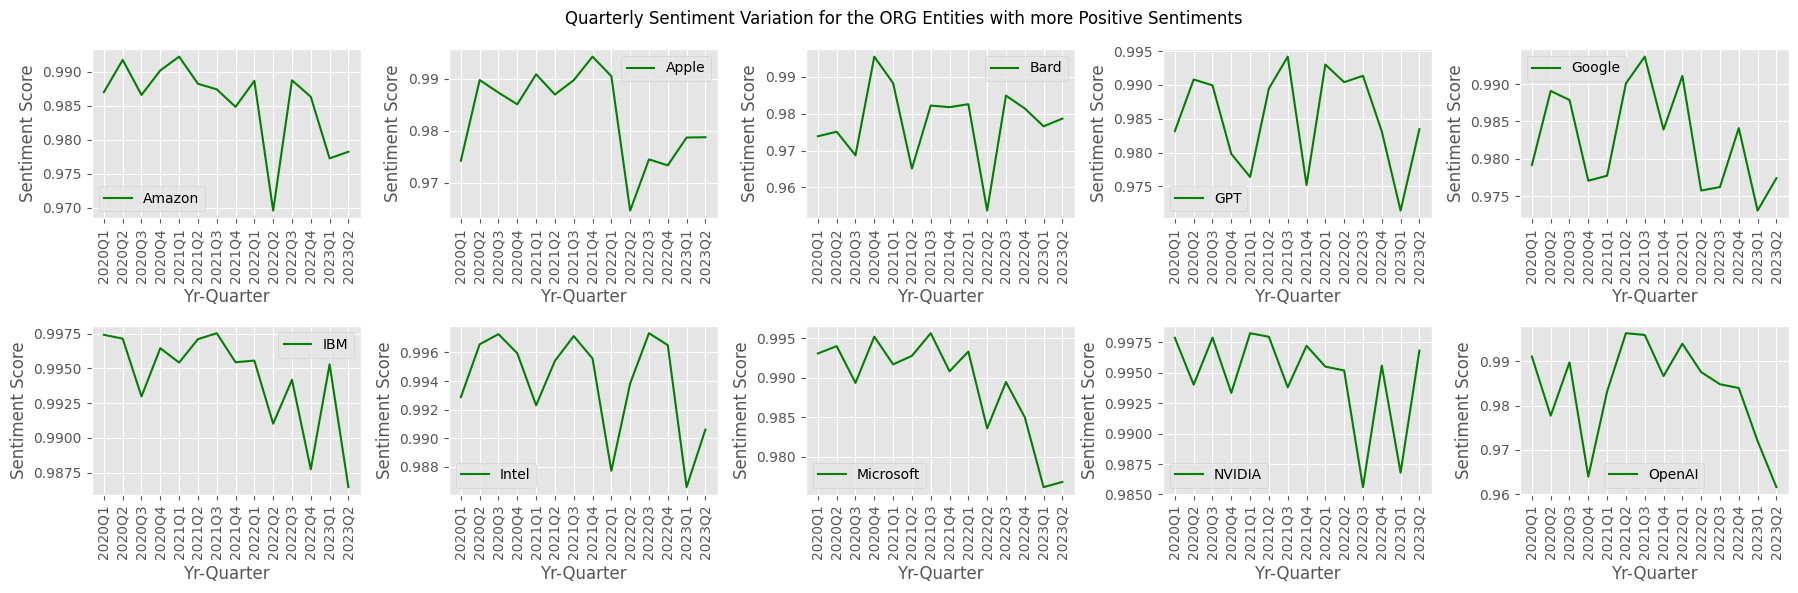

In [49]:
entity_quarter_sentiment = pos_entity_sentiment.groupby(['entities', 'quarter'])['sent_score'].mean().reset_index()

entities = entity_quarter_sentiment['entities'].unique()

num_cols = 5
num_rows = int((len(entities) + num_cols - 1) / num_cols)  

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6))
fig.tight_layout(pad=3.0)  # Adjust the padding between subplots
plt.style.use('ggplot')
# Iterate over the entities and plot the sentiment variation
for i, entity in enumerate(entities):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single row case
    entity_data = entity_quarter_sentiment[entity_quarter_sentiment['entities'] == entity]
    ent_data_sorted = entity_data.sort_values('quarter')  # Sort DataFrame by 'quarter' column
    sns.lineplot(data = ent_data_sorted, x=ent_data_sorted['quarter'].astype('str'), y= 'sent_score', color = 'green', ax= ax)

    ax.set_xlabel("Yr-Quarter")
    ax.set_ylabel("Sentiment Score")
    ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
    # ax.set_ylim(0.9, 1)  # Set the y-axis limits as needed
    ax.legend([entity])

# Hide empty subplots
if len(entities) < num_rows * num_cols:
    if num_rows > 1:
        for i in range(len(entities), num_rows * num_cols):
            axes.flatten()[i].axis('off')
    else:
        axes[num_cols].axis('off')

# Show the plot
fig.suptitle("Quarterly Sentiment Variation for the ORG Entities with more Positive Sentiments")
plt.tight_layout()
plt.show()

### Identify the articles and analyse sentiment variation with the negative entities

In [30]:
neg_ents_comb

,neg_org,org_freq,neg_loc,loc_freq,neg_person,person_freq
0,AI,48731,US,15388,Jones,2800
1,Google,7826,China,6029,Get Android,1965
2,Microsoft,7559,OpenAI,5958,Biden,1754
3,AP,3344,Us,4245,Twitter,1744
4,Trump,2467,India,3541,Musk,1530
5,EU,1701,Russia,3335,Covid,1475
6,GPT,1699,UK,3120,Donald Trump,1312
7,Bing,1657,Florida,3050,Elon Musk,1179
8,COVID,1617,Ukraine,2673,Ai Weiwei,1125
9,Bard,1480,New York,2556,Putin,879


In [37]:
neg_ents_orgs_lookup = ['Microsoft','Google','Gray Television Inc','Clearview AI','GPT','OpenAI','FBI','Amazon','Apple']

In [32]:
lookup_cats = ['health','logistics','finance','retail','manufacturing','legal','education']

In [86]:
pos_ents_lookup = ['Microsoft','Google','PRNewswire','Gray Television Inc', 
                   'IBM','GPT','Bard','OpenAI','Musk', 'India', 'United States']

neg_ents_lookup = ['Google','Microsoft','US','Biden','Trump','COVID','UK','Jones','GPT','OpenAI']

In [38]:
%%time
exploded_neg_articles = neg_df.explode('entities')
neg_filtered_df = exploded_neg_articles[exploded_neg_articles['entities'].isin(neg_ents_orgs_lookup)]

CPU times: user 409 ms, sys: 132 ms, total: 542 ms
Wall time: 540 ms


In [39]:
neg_filtered_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens',
       'entities', 'org_ents', 'loc_ents', 'person_ents'],
      dtype='object')

In [40]:
neg_entity_sentiment = neg_filtered_df.groupby(['year','quarter','month','date','entities'])[['sent_score']].mean().reset_index()
neg_entity_sentiment

,year,quarter,month,date,entities,sent_score
0,2020,2020Q1,1,2020-01-01,FBI,-0.979100
1,2020,2020Q1,1,2020-01-01,Google,-0.824914
2,2020,2020Q1,1,2020-01-01,Microsoft,-0.901367
3,2020,2020Q1,1,2020-01-02,Amazon,-0.878300
4,2020,2020Q1,1,2020-01-02,Apple,-0.878300
...,...,...,...,...,...,...
1976,2023,2023Q2,4,2023-04-28,FBI,-0.898250
1977,2023,2023Q2,4,2023-04-28,GPT,-0.887575
1978,2023,2023Q2,4,2023-04-28,Google,-0.754238
1979,2023,2023Q2,4,2023-04-28,Microsoft,-0.706300


In [141]:
# neg_entity_sentiment.to_csv('neg_entity_sentiment.csv')

/var/tmp/ipykernel_4462/715804846.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
/var/tmp/ipykernel_4462/715804846.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
/var/tmp/ipykernel_4462/715804846.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
/var/tmp/ipykernel_4462/715804846.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
/var/tmp/ipykernel_4462/715804846.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
/var/tmp/ipykernel_4462/715804846.py:23: UserWarning: FixedFormatter s

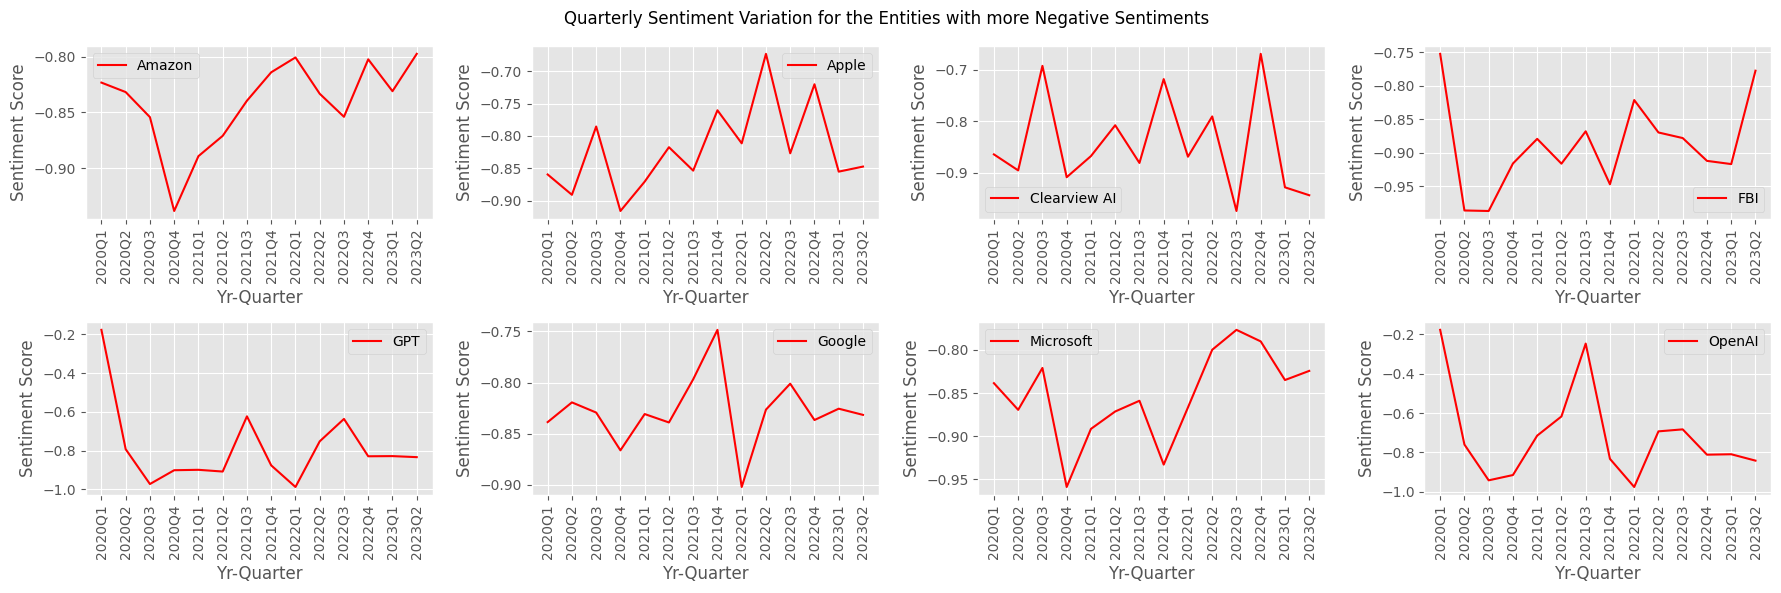

In [41]:
entity_quarter_sentiment = neg_entity_sentiment.groupby(['entities', 'quarter'])['sent_score'].mean().reset_index()

entities = entity_quarter_sentiment['entities'].unique()

num_cols = 4
num_rows = int((len(entities) + num_cols - 1) / num_cols)  

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6))
fig.tight_layout(pad=3.0)  # Adjust the padding between subplots
plt.style.use('ggplot')
# Iterate over the entities and plot the sentiment variation
for i, entity in enumerate(entities):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single row case
    entity_data = entity_quarter_sentiment[entity_quarter_sentiment['entities'] == entity]
    ent_data_sorted = entity_data.sort_values('quarter')  # Sort DataFrame by 'quarter' column
    sns.lineplot(data = ent_data_sorted, x=ent_data_sorted['quarter'].astype('str'), y= 'sent_score', color = 'red', ax= ax)

    ax.set_xlabel("Yr-Quarter")
    ax.set_ylabel("Sentiment Score")
    ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
    # ax.set_ylim(0.9, 1)  # Set the y-axis limits as needed
    ax.legend([entity])

# Hide empty subplots
if len(entities) < num_rows * num_cols:
    if num_rows > 1:
        for i in range(len(entities), num_rows * num_cols):
            axes.flatten()[i].axis('off')
    else:
        axes[num_cols].axis('off')

# Show the plot
fig.suptitle("Quarterly Sentiment Variation for the Entities with more Negative Sentiments")
plt.tight_layout()
plt.show()

In [96]:
entity_date_sentiment.date.dtypes

dtype('<M8[ns]')

In [76]:
%%time
total_df = pd.concat([pos_df, neg_df], ignore_index=True)
total_df.shape

CPU times: user 121 ms, sys: 7.22 ms, total: 128 ms
Wall time: 126 ms


(181923, 22)

## Tageted sentiment on industries

In [73]:
lookup_cats = ['health','logistics','finance','manufacturing','legal','education' ]

In [77]:
total_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens',
       'entities', 'org_ents', 'loc_ents', 'person_ents'],
      dtype='object')

In [78]:
%%time
filtered_cat_dfs = []

for category in lookup_cats:
    filtered_df = total_df[total_df['text_clean'].str.contains(category, case=False)]
    filtered_df = filtered_df[['text_clean', 'sent_score', 'date', 'year', 'quarter','month']]
    filtered_df['industry'] = category
    filtered_cat_dfs.append(filtered_df)

result_df = pd.concat(filtered_cat_dfs)

CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 1min 4s


In [80]:
grouped_cat = result_df.groupby(['year','quarter','month','date','industry'])[['sent_score']].agg('mean').reset_index()
grouped_cat

,year,quarter,month,date,industry,sent_score
0,2020,2020Q1,1,2020-01-01,education,0.833150
1,2020,2020Q1,1,2020-01-01,finance,0.979600
2,2020,2020Q1,1,2020-01-01,health,0.331947
3,2020,2020Q1,1,2020-01-01,legal,0.774750
4,2020,2020Q1,1,2020-01-01,logistics,0.999000
...,...,...,...,...,...,...
7213,2023,2023Q2,4,2023-04-28,finance,0.916059
7214,2023,2023Q2,4,2023-04-28,health,0.367667
7215,2023,2023Q2,4,2023-04-28,legal,0.682296
7216,2023,2023Q2,4,2023-04-28,logistics,0.831500


/var/tmp/ipykernel_4462/3859768263.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 20)` for the same effect.

  sns.lineplot(data = cat_sorted, x=cat_sorted['quarter'].astype('str'), y= 'sent_score', hue ='industry', palette = "bright", ci=20)


Text(0.5, 1.0, 'Sentiment Variation Timeline For Different Industries')

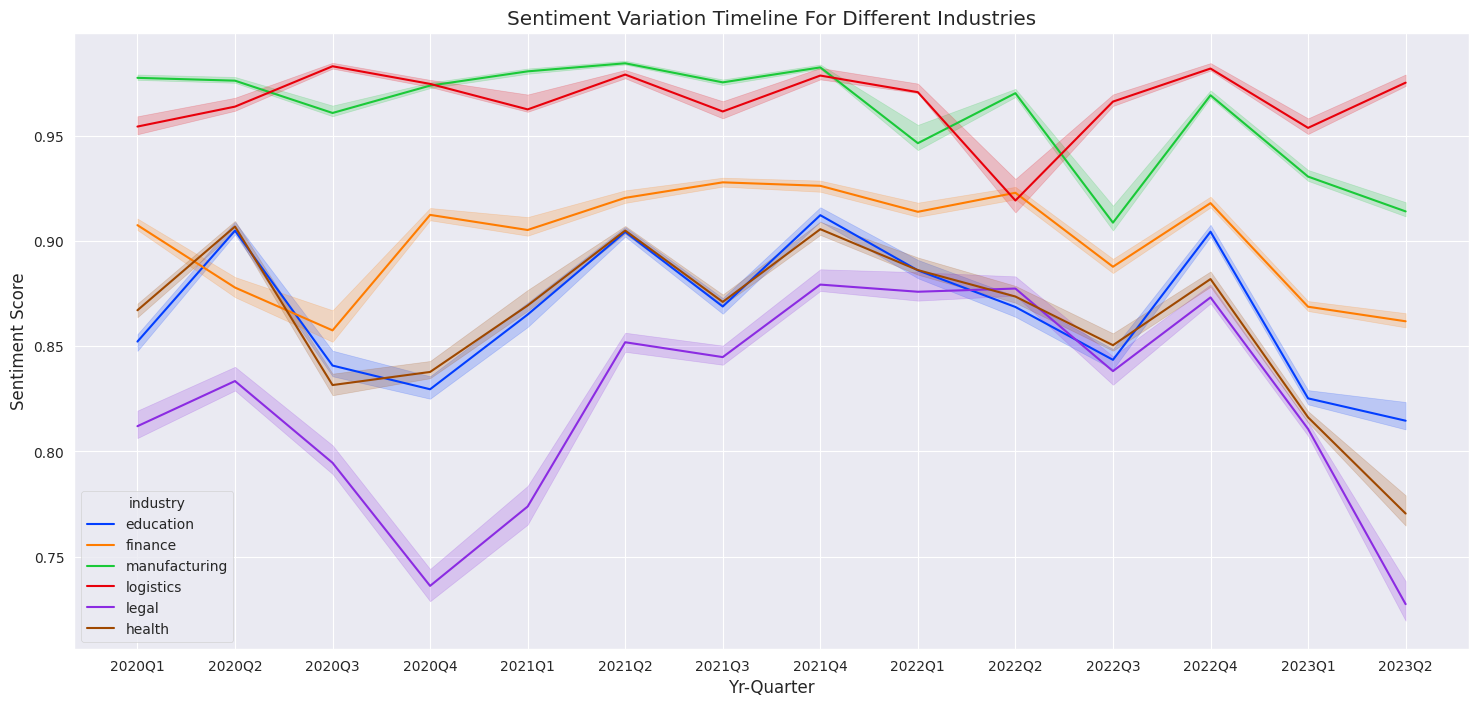

In [83]:
#Monthly Positive sentiment variation over time by average value
plt.figure(figsize=(18,8))
sns.set_style('darkgrid')
cat_sorted = grouped_cat.sort_values('quarter')  # Sort DataFrame by 'quarter' column
sns.lineplot(data = cat_sorted, x=cat_sorted['quarter'].astype('str'), y= 'sent_score', hue ='industry', palette = "bright", ci=20)
plt.xlabel("Yr-Quarter")
# plt.xticks(ticks = list(range(1,13)),rotation = 0)
plt.ylabel("Sentiment Score")
plt.title("Sentiment Variation Timeline For Different Industries")

### Identify the articles and analyse sentiment variation with the positive entities

In [52]:
%%time
exploded_pos_articles = pos_df.explode('entities')
pos_filtered_df = exploded_pos_articles[exploded_pos_articles['entities'].isin(pos_ents_lookup)]

CPU times: user 6.24 s, sys: 2.13 s, total: 8.36 s
Wall time: 8.36 s


In [53]:
pos_filtered_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens',
       'entities', 'org_ents', 'loc_ents', 'person_ents'],
      dtype='object')

In [54]:
pos_entity_sentiment = pos_filtered_df.groupby(['year','quarter','month','date','entities'])[['sent_score']].mean().reset_index()
pos_entity_sentiment.head(10)

,year,quarter,month,date,entities,sent_score
0,2020,2020Q1,1,2020-01-01,Google,0.842964
1,2020,2020Q1,1,2020-01-01,IBM,0.998467
2,2020,2020Q1,1,2020-01-01,India,0.983093
3,2020,2020Q1,1,2020-01-01,Microsoft,0.998233
4,2020,2020Q1,1,2020-01-01,United States,0.982063
5,2020,2020Q1,1,2020-01-02,Google,0.970000
6,2020,2020Q1,1,2020-01-02,IBM,0.998121
7,2020,2020Q1,1,2020-01-02,India,0.984574
8,2020,2020Q1,1,2020-01-02,Microsoft,0.997250
9,2020,2020Q1,1,2020-01-02,United States,0.941759


In [55]:
# pos_entity_sentiment.to_csv('pos_entity_sentiment.csv')

In [56]:
# sns.lineplot(data=entity_data, x='quarter', y='sent_score', color='tab:blue', ax=ax)
entity_data.dtypes

entities             object
quarter       period[Q-DEC]
sent_score          float64
dtype: object

/var/tmp/ipykernel_4493/4124378369.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4124378369.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4124378369.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4124378369.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4124378369.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4124378369.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4124378369.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4124378369.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4124378369.py:23: UserWa

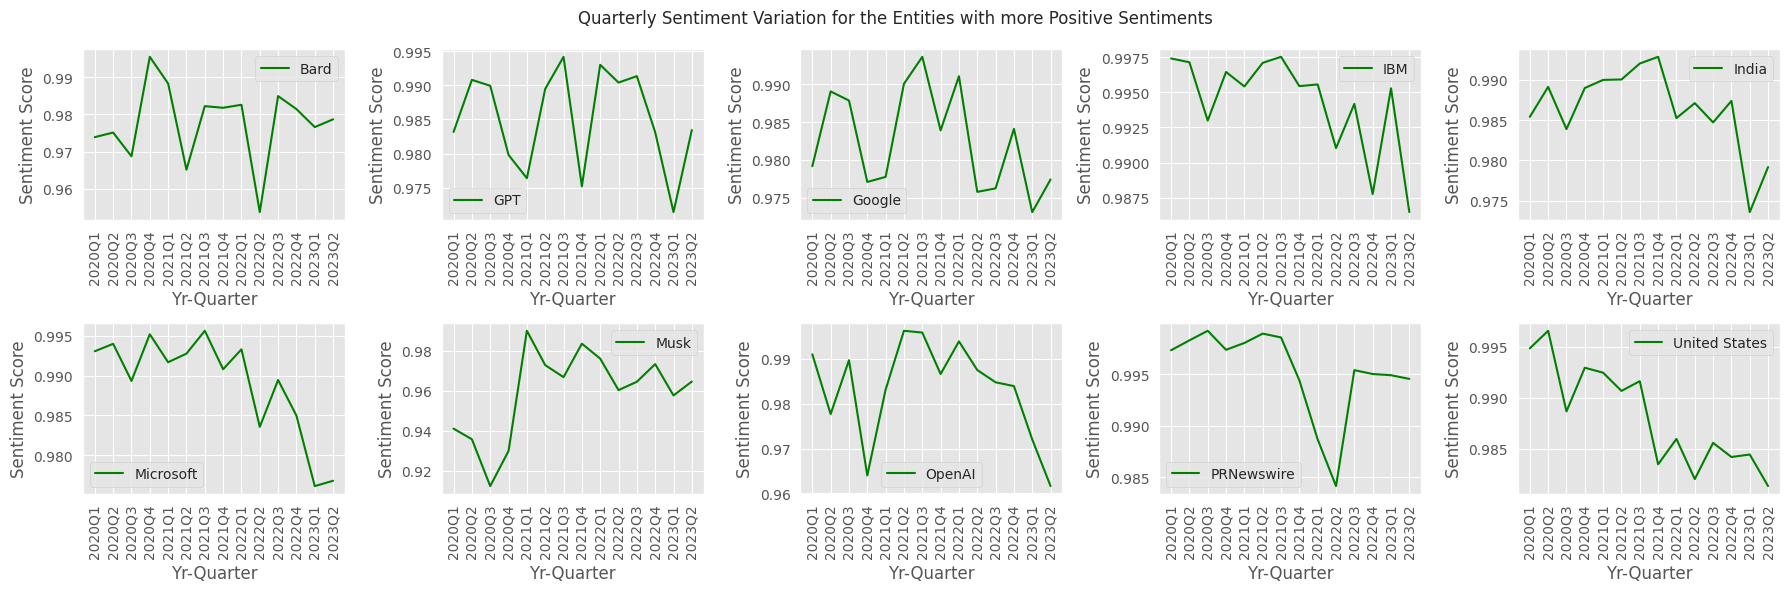

In [80]:
entity_quarter_sentiment = pos_entity_sentiment.groupby(['entities', 'quarter'])['sent_score'].mean().reset_index()

entities = entity_quarter_sentiment['entities'].unique()

num_cols = 5
num_rows = int((len(entities) + num_cols - 1) / num_cols)  

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6))
fig.tight_layout(pad=3.0)  # Adjust the padding between subplots
plt.style.use('ggplot')
# Iterate over the entities and plot the sentiment variation
for i, entity in enumerate(entities):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single row case
    entity_data = entity_quarter_sentiment[entity_quarter_sentiment['entities'] == entity]
    ent_data_sorted = entity_data.sort_values('quarter')  # Sort DataFrame by 'quarter' column
    sns.lineplot(data = ent_data_sorted, x=ent_data_sorted['quarter'].astype('str'), y= 'sent_score', color = 'green', ax= ax)

    ax.set_xlabel("Yr-Quarter")
    ax.set_ylabel("Sentiment Score")
    ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
    # ax.set_ylim(0.9, 1)  # Set the y-axis limits as needed
    ax.legend([entity])

# Hide empty subplots
if len(entities) < num_rows * num_cols:
    if num_rows > 1:
        for i in range(len(entities), num_rows * num_cols):
            axes.flatten()[i].axis('off')
    else:
        axes[num_cols].axis('off')

# Show the plot
fig.suptitle("Quarterly Sentiment Variation for the Entities with more Positive Sentiments")
plt.tight_layout()
plt.show()

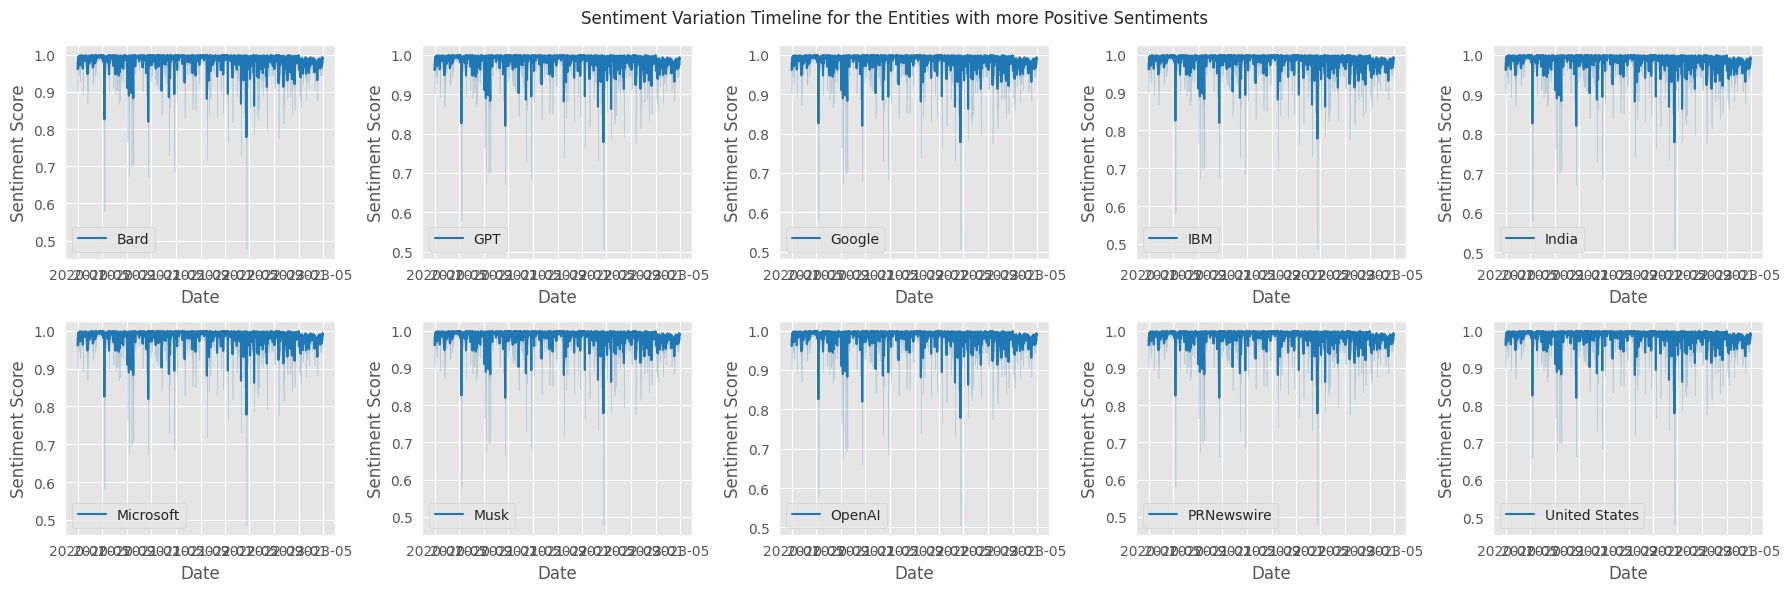

In [72]:
entity_date_sentiment = pos_entity_sentiment.groupby(['entities', 'date'])['sent_score'].mean().reset_index()

entities = entity_date_sentiment['entities'].unique()

num_cols = 5
num_rows = int((len(entities) + num_cols - 1) / num_cols)  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6))
fig.tight_layout(pad=3.0)  # Adjust the padding between subplots
plt.style.use('ggplot')
for i, entity in enumerate(entities):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single row case
    sns.lineplot(data = entity_date_sentiment, x='date', y= 'sent_score', color = 'tab:blue', ax= ax)

    ax.set_xlabel("Date")
    ax.set_ylabel("Sentiment Score")
    # ax.set_ylim(0.9, 1)  # Set the y-axis limits as needed
    ax.legend([entity])

if len(entities) < num_rows * num_cols:
    if num_rows > 1:
        for i in range(len(entities), num_rows * num_cols):
            axes.flatten()[i].axis('off')
    else:
        axes[num_cols].axis('off')

fig.suptitle("Sentiment Variation Timeline for the Entities with more Positive Sentiments")
plt.tight_layout()
plt.show()

### Identify the articles and analyse sentiment variation with the negative entities

In [87]:
%%time
exploded_neg_articles = neg_df.explode('entities')
neg_filtered_df = exploded_neg_articles[exploded_neg_articles['entities'].isin(neg_ents_lookup)]

CPU times: user 446 ms, sys: 92.1 ms, total: 538 ms
Wall time: 537 ms


In [88]:
neg_filtered_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens',
       'entities', 'org_ents', 'loc_ents', 'person_ents'],
      dtype='object')

In [89]:
neg_entity_sentiment = neg_filtered_df.groupby(['year','quarter','month','date','entities'])[['sent_score']].mean().reset_index()
neg_entity_sentiment

,year,quarter,month,date,entities,sent_score
0,2020,2020Q1,1,2020-01-01,Google,-0.824914
1,2020,2020Q1,1,2020-01-01,Microsoft,-0.901367
2,2020,2020Q1,1,2020-01-01,Trump,-0.980333
3,2020,2020Q1,1,2020-01-01,UK,-0.920575
4,2020,2020Q1,1,2020-01-01,US,-0.846471
...,...,...,...,...,...,...
3943,2023,2023Q2,4,2023-04-28,Microsoft,-0.706300
3944,2023,2023Q2,4,2023-04-28,OpenAI,-0.878969
3945,2023,2023Q2,4,2023-04-28,Trump,-0.914743
3946,2023,2023Q2,4,2023-04-28,UK,-0.894433


In [141]:
# neg_entity_sentiment.to_csv('neg_entity_sentiment.csv')

/var/tmp/ipykernel_4493/4119161124.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4119161124.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4119161124.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4119161124.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4119161124.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4119161124.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4119161124.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4119161124.py:23: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/4119161124.py:23: UserWa

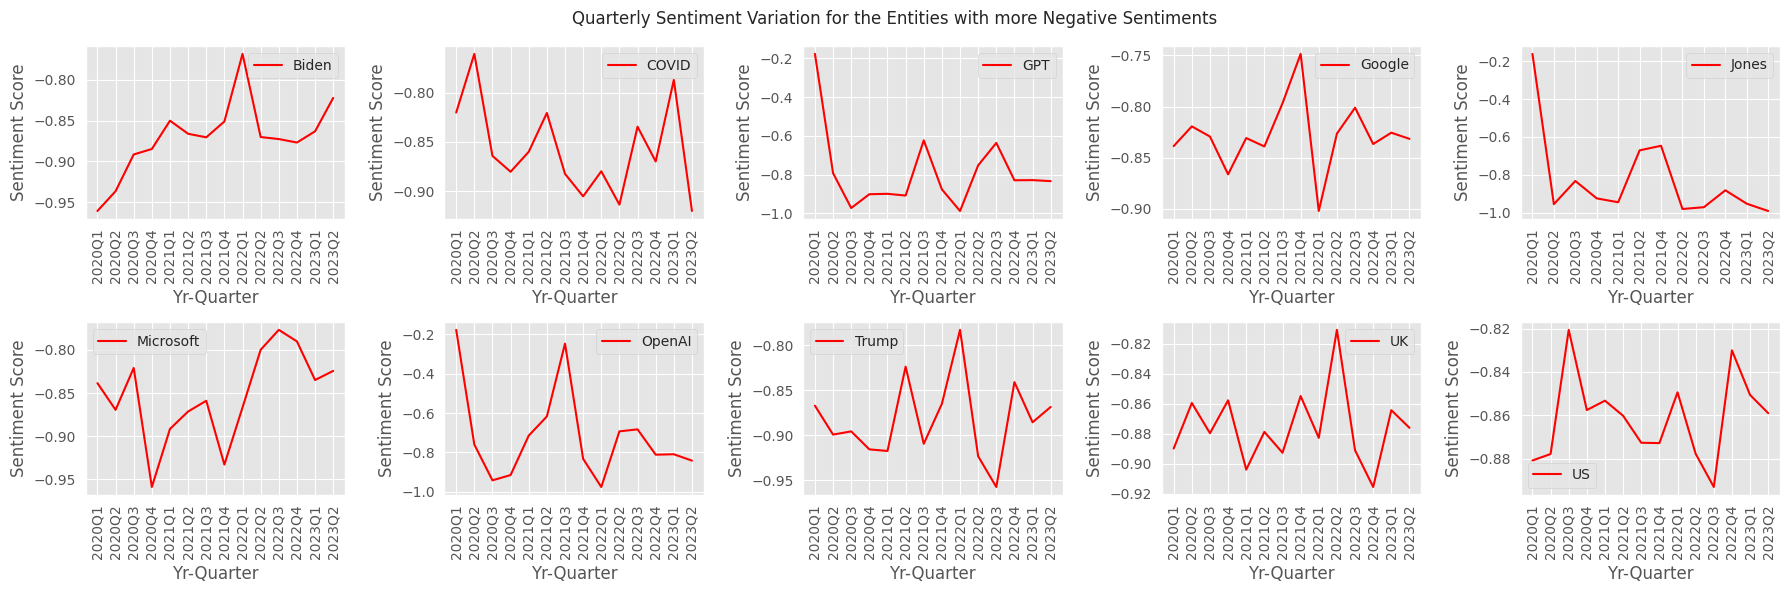

In [92]:
entity_quarter_sentiment = neg_entity_sentiment.groupby(['entities', 'quarter'])['sent_score'].mean().reset_index()

entities = entity_quarter_sentiment['entities'].unique()

num_cols = 5
num_rows = int((len(entities) + num_cols - 1) / num_cols)  

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6))
fig.tight_layout(pad=3.0)  # Adjust the padding between subplots
plt.style.use('ggplot')
# Iterate over the entities and plot the sentiment variation
for i, entity in enumerate(entities):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single row case
    entity_data = entity_quarter_sentiment[entity_quarter_sentiment['entities'] == entity]
    ent_data_sorted = entity_data.sort_values('quarter')  # Sort DataFrame by 'quarter' column
    sns.lineplot(data = ent_data_sorted, x=ent_data_sorted['quarter'].astype('str'), y= 'sent_score', color = 'red', ax= ax)

    ax.set_xlabel("Yr-Quarter")
    ax.set_ylabel("Sentiment Score")
    ax.set_xticklabels(entity_data['quarter'].astype(str), rotation=90)
    # ax.set_ylim(0.9, 1)  # Set the y-axis limits as needed
    ax.legend([entity])

# Hide empty subplots
if len(entities) < num_rows * num_cols:
    if num_rows > 1:
        for i in range(len(entities), num_rows * num_cols):
            axes.flatten()[i].axis('off')
    else:
        axes[num_cols].axis('off')

# Show the plot
fig.suptitle("Quarterly Sentiment Variation for the Entities with more Negative Sentiments")
plt.tight_layout()
plt.show()

In [96]:
entity_date_sentiment.date.dtypes

dtype('<M8[ns]')

/var/tmp/ipykernel_4493/1024162219.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/1024162219.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/1024162219.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/1024162219.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/1024162219.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/1024162219.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/1024162219.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/1024162219.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/tmp/ipykernel_4493/1024162219.py:21: UserWa

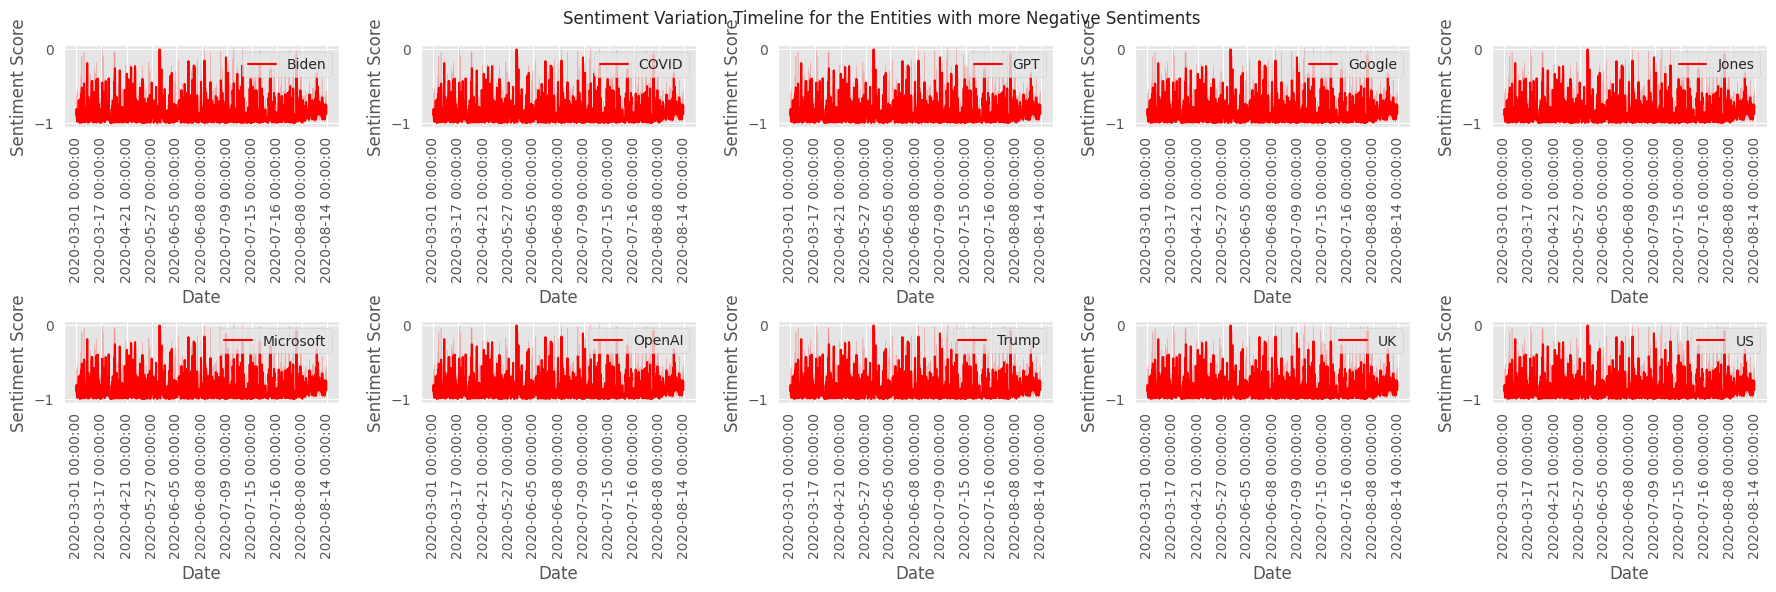

In [97]:
entity_date_sentiment = neg_entity_sentiment.groupby(['entities', 'date'])['sent_score'].mean().reset_index()

entities = entity_date_sentiment['entities'].unique()

num_cols = 5
num_rows = int((len(entities) + num_cols - 1) / num_cols)  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6))
fig.tight_layout(pad=3.0)  # Adjust the padding between subplots
plt.style.use('ggplot')
for i, entity in enumerate(entities):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]  # Handle single row case
    sns.lineplot(data = entity_date_sentiment, x=entity_date_sentiment['date'].dt.date, y= 'sent_score', color = 'red', ax= ax)

    ax.set_xlabel("Date")
    ax.set_ylabel("Sentiment Score")
    # ax.set_ylim(0.9, 1)  # Set the y-axis limits as needed
    ax.legend([entity])
    ax.set_xticklabels(entity_date_sentiment['date'], rotation=90) 

if len(entities) < num_rows * num_cols:
    if num_rows > 1:
        for i in range(len(entities), num_rows * num_cols):
            axes.flatten()[i].axis('off')
    else:
        axes[num_cols].axis('off')

fig.suptitle("Sentiment Variation Timeline for the Entities with more Negative Sentiments")
plt.tight_layout()
plt.show()